# ECBM 4040 Fall 2020 FINAL PROJECT 

### Author:

Wenjun Yang (wy2347)   

Qihang Yang (qy2231)

In [2]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf

In [4]:
from utils.prep import *
from utils.model import *
from utils.visualizeMIDI import *

## Step 1: Extract the midi data from zip file.

* the data we use in this project comes from [Classical Piano Midi Page](http://www.piano-midi.de/) 
* all of them are midi file containing two tracks of piano for left hand and right hand


In [ ]:
## you don't have to run this block

# import zipfile
# with zipfile.ZipFile('data/midifile.zip', 'r') as zip_ref:
#     zip_ref.extractall('data/')

## Step 2: Prepare data for training

#### A little insight about the input data structure
The input data proposed by the original paper is a little bit complex and requires some knowledge about music. \
For more information on background knowledge of music, you can refer to the following two links:
* [MIDI_events](https://www.mixagesoftware.com/en/midikit/help/HTML/midi_events.html#:~:text=The%20Note%20Off%20Event%20is,hard%20the%20key%20was%20released.) 
* [MIDI Turtorial](http://www.music-software-development.com/midi-tutorial.html) 

We spend quite a lot time trying to figure out the whole logic behind this and provide the following glossary table for your information.\
And for consistency, we will stick to the name convention stated in the original paper.

* stateMatrix: matrix of state, for state definition see below
* note: 0-77 lower_bound=24; upper_bound=102 
* part_position(1) = note
* pitchclass = 1 of 12 half steps CDEFGAB b#
* part_pitchclass(12): one-hot pitchclass 
* state: (1,0) (1,1) (0,0) -> denoting holding or repeating a note
* context: the count of each pitchclass played in last timestep 
* part_context(12): rearranged context
* part_prev_proximity(50):

#### Note:
* input for model: part_position + part_pitchclass + part_prev_vicinity + part_context + beat + [0] 
* total number of arguments: 1 + 12 + 50 + 12 + 4 + 1 = 80
* for each of the 78 note you have 80 arguments in above structure
* and we only use sequences of 128 timesteps for training
* so the input data form will be 128 X 78 X 80

Please refer to prep.py for the details of implementation of data preprocessing part.

The general data preparation process is as the following flowchart:
<img src="image/Data Prep.png" />


In [1]:
training_data = load_data('data/music')

## (Optional) Step 3: Train the theano-based model

In [5]:
# from Original.ori_prep import *
# from Original.ori_multi_training import *
# from Original.ori_model import *

In [47]:
# pcs = loadPieces("data/music")
# m = Model([300,300],[100,50], dropout=0.5)

In [ ]:
# trainPiece(m, pcs, 100) 

## Step 4: Our Work

### 4.1 Workflow

The general workflow of our project is as follows:
<img src="image/workflow.png" />


We train our model which is written in tensorflow and keras, predict and generate music based on our model, then compare our output music with the products of the original paper.\
Our methodology generally follows a similar pattern with the original paper, but also differs in several ways. To start with, our project uses tensorflow and keras to implement the paper while the original paper is based on theano. Also, with limited time and computing resources, we only manage to train the model for 1050 epochs in contrast to 10000 epochs in the original paper, that might cause huge differences in the output. To see the exact architecture we are using and details of training, please refer to section 4.2 and 4.3.

### 4.2 Model

#### The Bi-axial model
The Bi-axial model proposed by the original paper stacks LSTM first in time axis then in note axis. The first two layers are independent in notes, but have connection across time. The last two layers are connected in the note axis while independent across time. Its structure is displayed in the below picture, note the loop means delay by one time step.
<img src="image/architecture.png" />
This structure is aimed at capturing the intrinsic feature of model, that is time-dependence, note-invariance and chord.

#### The Software Implementation:
The tensorflow/Keras implementation of our model is as the below diagram.
Note that our model involves 2 transpose layers in order to change the structure of input data into the form that caters to the time-distributed layers. Also note even though we have two separate layers in the diagram, in practice, we combine these 2 together and form a single input layer.
<img src="image/model.png" />
For code please refer to model.py

### 4.3 Training (No need to run this section)
We train our model for 1050 epochs with 20 steps for each epoch and 10 samples for each step, each sample is of length 128 time steps according to the original paper. We use Adam optimizer with a learning rate of 5e-5 and a custom loss function calculating the negative log likelihood of our output against the true state matrix of note being played next time step.


Details about loss function:\
Because that the prediction is probability, we create our loss function by modified on the binary entropy:
$$ C = - \sum_{t=1}^T \sum_{n=1}^N \ln [v_n^{(t)}q^{(n,t)} + (1 - v_n^{(t)})(1 - q^{(n,t)})] $$
where $q^{(n,t)}$ represent the prediction of $p^{(t)}(v_n=1|v_{<n})$. 


In [11]:
model = music_gen()

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(5e-5),loss= my_loss)

In [11]:
model.build(input_shape = (None, 127, 78, 82)) # Training shape
# model.summary()
filepath="models/model-epoch-{epoch:02d}.h5"
save_callback=tf.keras.callbacks.ModelCheckpoint(filepath,  
                                              verbose=0, save_best_only=False, 
                                              save_weights_only=True, period=50)

In [49]:
data_gen=update_input_batch_generator(training_data)
model.fit_generator(data_gen,epochs=600,steps_per_epoch=20,callbacks=[save_callback])

Note: Due to limitation of storage space of github, unfortunately, the model file can't be pushed into github,
however you may find the saved model file following the link below. Download it and save it back to the folder specified above, then you can easily proceed to the next step. 

https://drive.google.com/file/d/1SFWloQ0ukVv9Lr7ieN98HmfeFsEEWxJz/view?usp=sharing

We are opening view access to everyone with lionmail, if you have trouble downloading that, please feel free to contact us.

### 4.4 Predition and Music generation
After the model is built and trained, our next step is to use the prediction of our model to generate original music pieces. We randomly select a music piece in our training data and use its first 127 timesteps as a starting data to make a prediction. The prediction is the probability of the state matrix to be positive of the note at time step 128. We create a uniformly random variable and compare it with the probability to derive an actual state matrix of this note. We transfer the state matrix to the input data type and concatenate it to our starting data, and select the last 127 timesteps as our new training data. Keep it on and we can continually generate a long list of data. Choose the ideal length of the data matrix and transfer it back to a midi file, we finally generate an original music piece.

In [26]:
model = music_gen()

In [28]:
model.build(input_shape = (None, 127, 78, 82)) 
model.load_weights("model/model-epoch-1050.h5")

We use a more visually appealing way to to show the music generated. To see the code of visualization part, please refer to visualizeMIDI.py. Below is a random music piece generated by our model, you can find the MIDI file under samples folder.\
We will also generate a piece of music from initial model with random initialztion, to show the improvement we have in music generation.

sample.mid saved


/home/ecbm4040/anaconda3/envs/envTF22/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


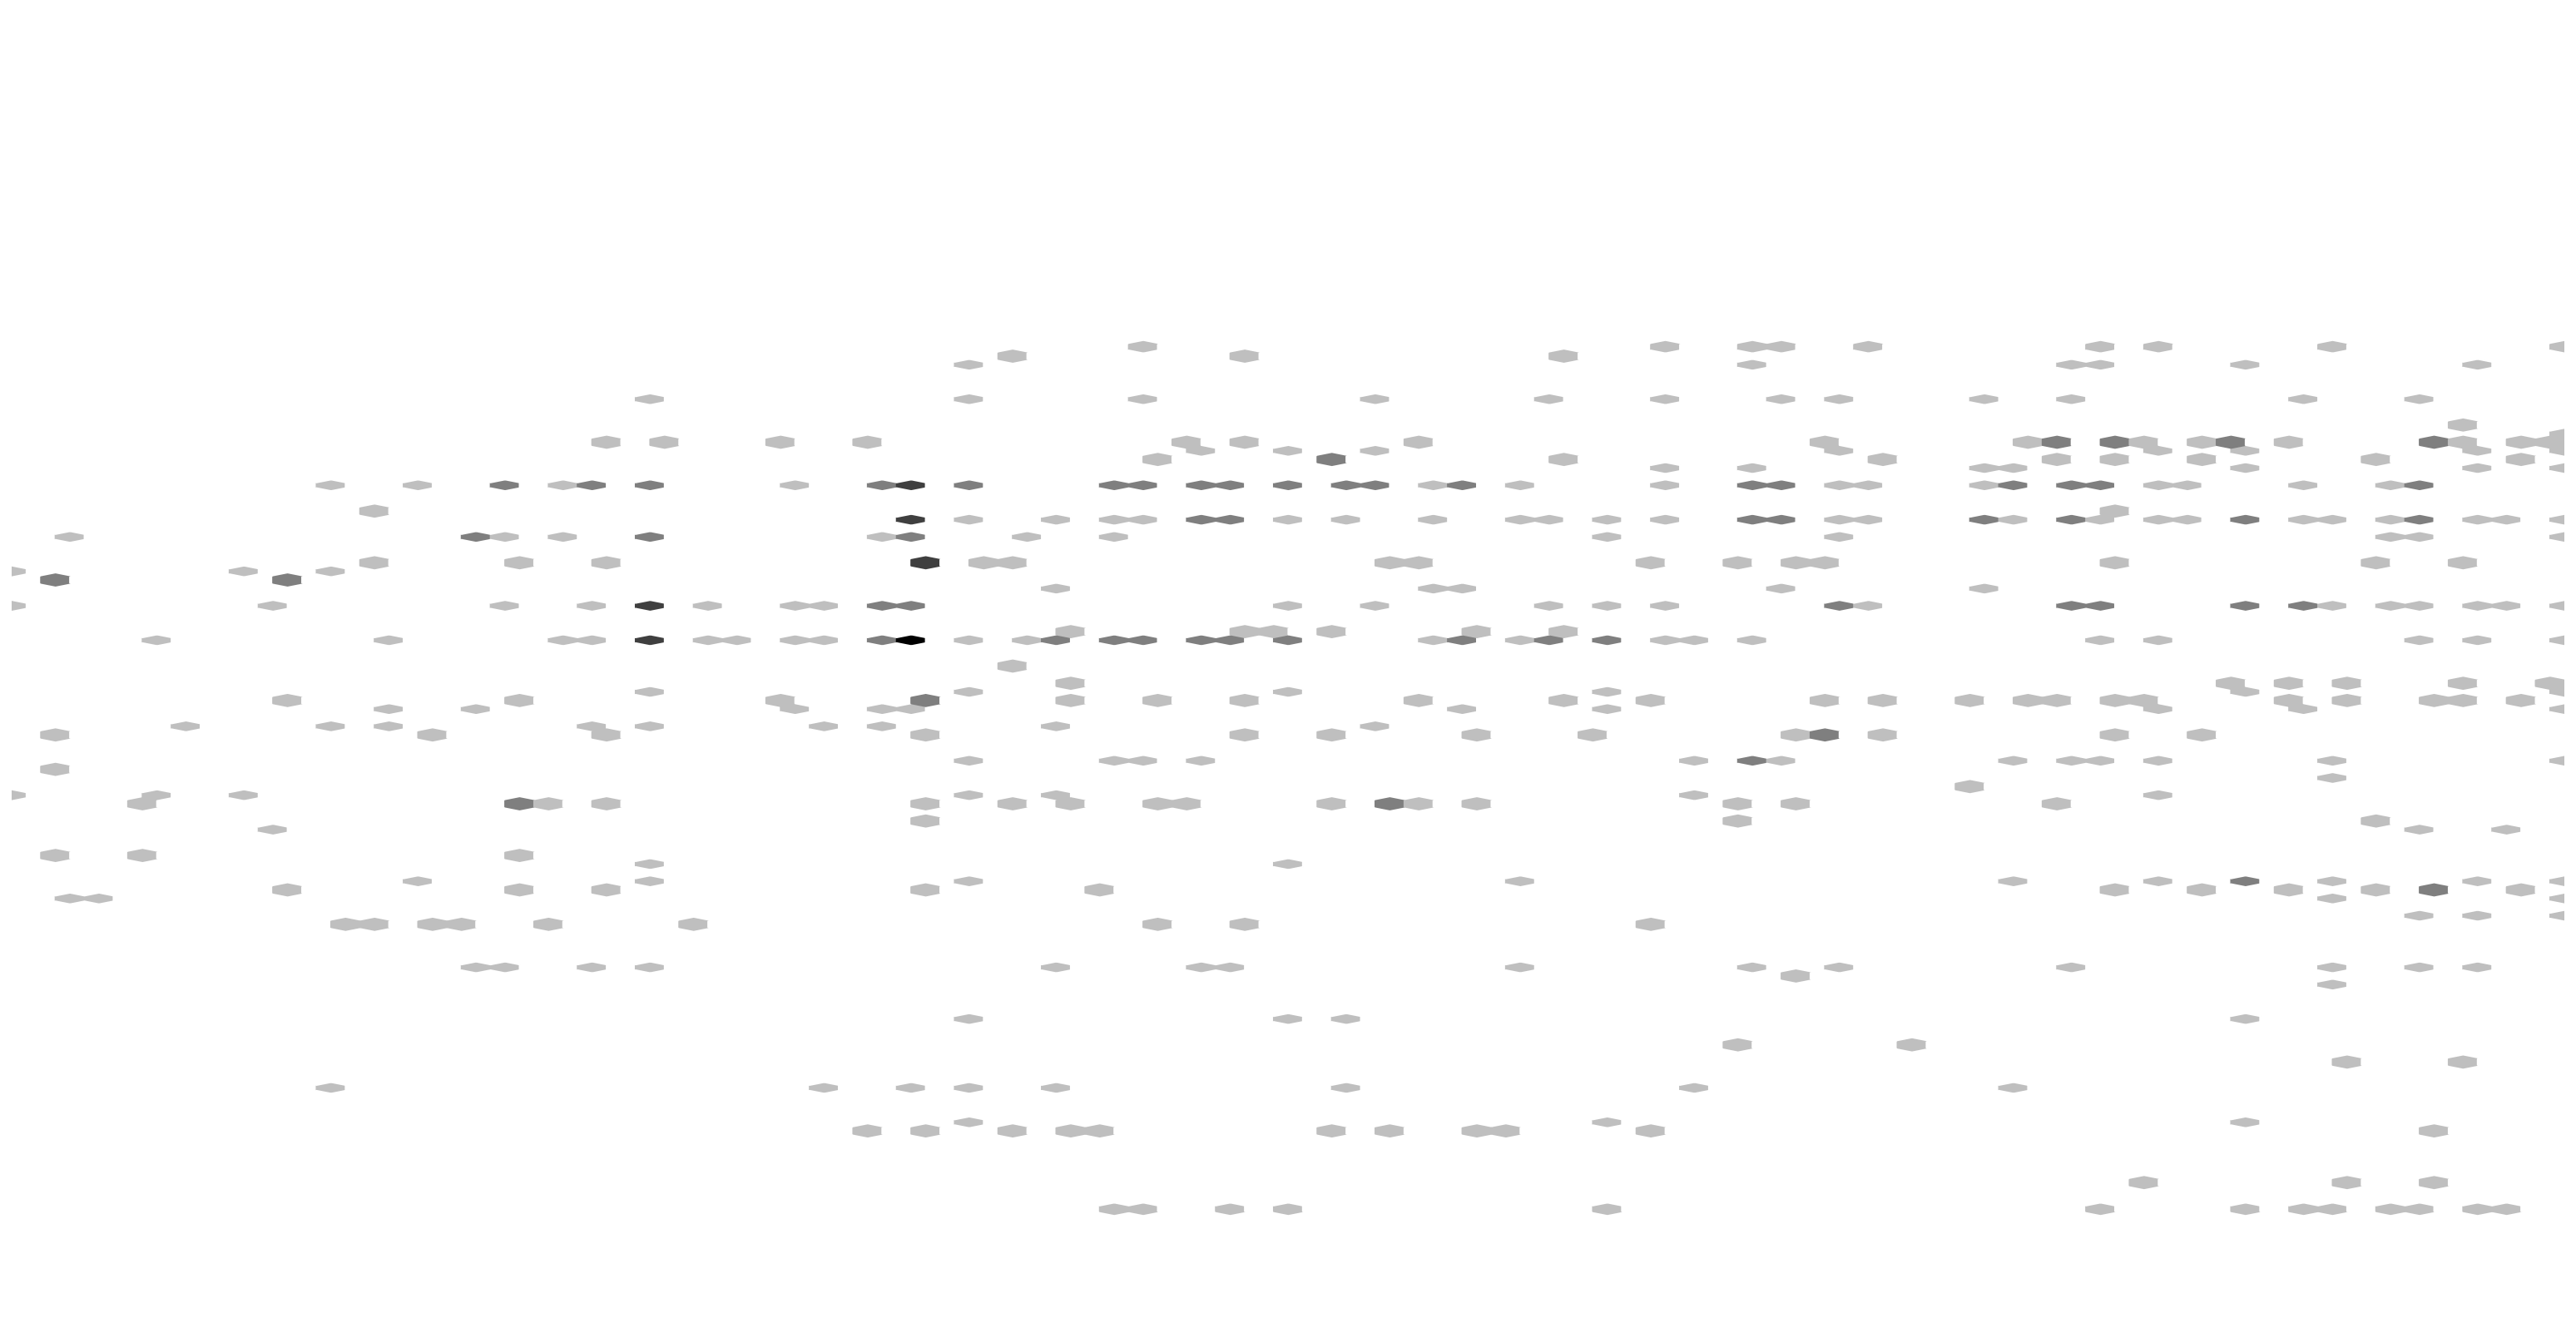

In [35]:
# Parameters:
# # starting_data: randomly choose a starting_data from training_data
# # length: the length of music to be composed,
# # name: file name
import midi

starting_data = build_single_input(training_data) 
model.compose(starting_data, length = 100, name = "sample")

mid=midi.read_midifile('samples/sample.mid')
visualize_midi(mid)

#### Model with Random Initialization

In [2]:
model=music_gen()
model.build(input_shape = (None, 127, 78, 82))
starting_data = build_single_input(training_data) 
model.compose(starting_data, length = 100, name = "sample_prob_random")

/home/ecbm4040/anaconda3/envs/envTF22/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


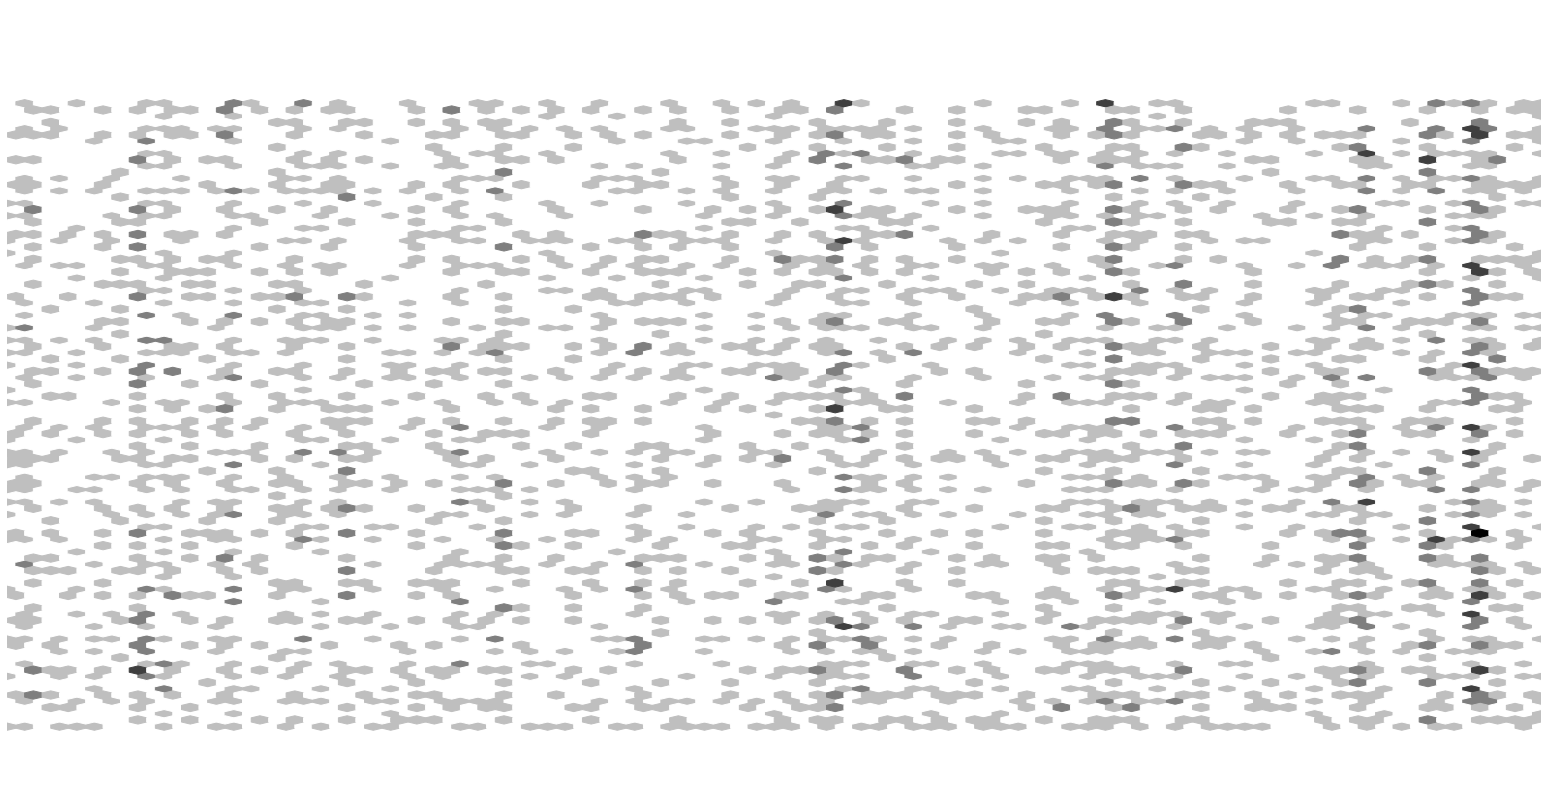

In [36]:
mid=midi.read_midifile('samples/sample_prob_random.mid')
visualize_midi(mid)

From the two picture above, we could see that the model really learn the dependency between the time steps and notes based on the fact that they are much less haphazard and notes often come in as pairs which compose chords. And try listening, you can see more improvement. 

### Step 5: Result

We generate a few pieces of music and select some of our best products for display.\
If you run this notebook, you can play the music down below.\
Otherwise, you can take a look at them under samples folder.

In [8]:
from music21 import midi as mmd
def playmusic(midfile):
    music=mmd.MidiFile()
    music.open(midfile)
    music.read()
    music.close()
    sound=mmd.translate.midiFileToStream(music)
    sound.show('midi')

In [11]:
playmusic('samples/sample_prob_new_2.mid')

In [12]:
playmusic('samples/sample_prob_new_4.mid')

In [13]:
playmusic('samples/sample_prob_new_6.mid')

### Step 6: Conclusion

In this project, we reconstructed the Bi-axial LSTM model in tensorflow and Keras. After epochs of training, we predict the next note timestep by timestep, and eventually generating pieces of music. 

We learned many lessons in this project:
* A key point in the original paper is that it uses state matrix to represent midi files cleverly, which makes the prediction by deep learning model more feasible. How to deal with the complicated data is the key issue in this kind of problem. The displacement of state matrices in training data also makes the LSTM more meaningful, which is a creative idea.
* A proper deep learning model should take more data properties into consideration, and this Bi-axial model can take care of both the input data and its state matrix, along with the time sequence, improving the performance of the original LSTM model.
* The number of training epochs really make a significant difference in a large deep learning model, and it is easy for the training time to exceed several hours. Also we have trained our model for 1000 epochs, the output still can be improved.


### Step 7: Difference 

Our implementation differs with the original paper in the following ways:
* First is the difference of deep learning framework. The original paper used theano to create their model, but theano is a little outdated at present. We changed to use tensorflow, which is more familiar to us.  The implementation of the deep learning model also needs to be adjusted, but the structures of the model are similar.
* We used different optimizers to train our model. The original paper used RMSprop with a learning rate of 0.001 as their optimizer , but we chose  Adam with a learning rate of 5e-5 to increase the training spend and accuracy. 
* The original paper used the average of the binary cross entropy as the loss function. As for making the loss more obvious, we used the sum of binary cross entropy as our cost, and this change causes little difference.
* As to the training epochs, because that the model training takes a long time, we did not train as many times as the original paper, and used 1000 epochs as the number of iterations, and we think the output is meaningful enough.


### Step 8: Unsolved problems and Drawbacks

Many potential improvements have been left for the future due to lack of time. Future work will involve deeper analysis of current mechanisms and also trying different methods. 
* In particular, due to lack of time and computing resources, we only managed to train our model for 1050 epochs. Thus, priority will be given to further training. 
* Moreover, velocity in the current model is fixed at a hand-pick value, which is partly due to the nature of the current dataset. However, music with only one velocity would be very bland, skilled pianists often have their own interpretation of the music and emotions, which results in the different velocity and style even in the same note of the same song. It would be nice to cover some performance or style in the model. Many researchers have carried out similar research, many of them use datasets of MIDI music of skilled pianists and some of them successfully predict the notes and also their expressive timing and dynamics. 
* Bidirectional LSTM is also a promising field to look at. Generally, Bidirectional LSTM provides a more thorough view of the entire sequence, which would be nice to be applied to music generation, because music usually is a sequence of notes that follow the same style and interdependent across time. Plus, Bidirectional LSTM provides faster and even fuller learning of the problem. 
